In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

def add_martingale_motion(data, volatility=0.01):

    close_values = data['close'].str.replace(',', '').astype(float).values
    brownian_motion = np.cumsum(np.random.normal(0, 1, size=len(close_values)))  # B(t)
    martingale_values = close_values[0] + volatility * brownian_motion
    data['close_martingale'] = martingale_values
    return data

def simulate_gbm(S0, mu, sigma, T, steps, num_simulations):
    dt = T / steps
    simulations = []

    for _ in range(num_simulations):
        path = [S0]
        for t in range(steps):
            dW = np.random.normal(0, np.sqrt(dt))
            next_price = path[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
            path.append(next_price)
        simulations.append(path)

    return np.array(simulations)

def optimal_stopping_backtest(prices, threshold=0.1):
    initial_balance = 10000
    balance = initial_balance
    stock = 0
    for price in prices:
        if price > prices[0] * (1 + threshold):
            if balance >= price:
                balance -= price
                stock += 1
        elif price < prices[0] * (1 - threshold):
            if stock > 0:
                balance += price
                stock -= 1
    balance += stock * prices[-1]
    return balance, (balance - initial_balance) / initial_balance

def plot_stock_data(actual_prices, predicted_prices):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, label='Actual Price', color='blue')
    plt.plot(predicted_prices, label='Predicted Price (GBM)', color='red', linestyle='dashed')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time (Days)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_simulation(simulations, title="Simulated Stock Price Paths"):
    plt.figure(figsize=(10, 6))
    for sim in simulations:
        plt.plot(sim, color='blue', alpha=0.2)
    plt.title(title)
    plt.xlabel('Time (Days)')
    plt.ylabel('Price')
    plt.show()

In [39]:
file_path = '/content/Quote-Equity-HAL-EQ-26-11-2023-to-26-11-2024.csv'
data = load_data(file_path)

data = add_martingale_motion(data, volatility=0.02)

actual_prices = data['close'].str.replace(',', '').astype(float).values

log_returns = np.diff(np.log(actual_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

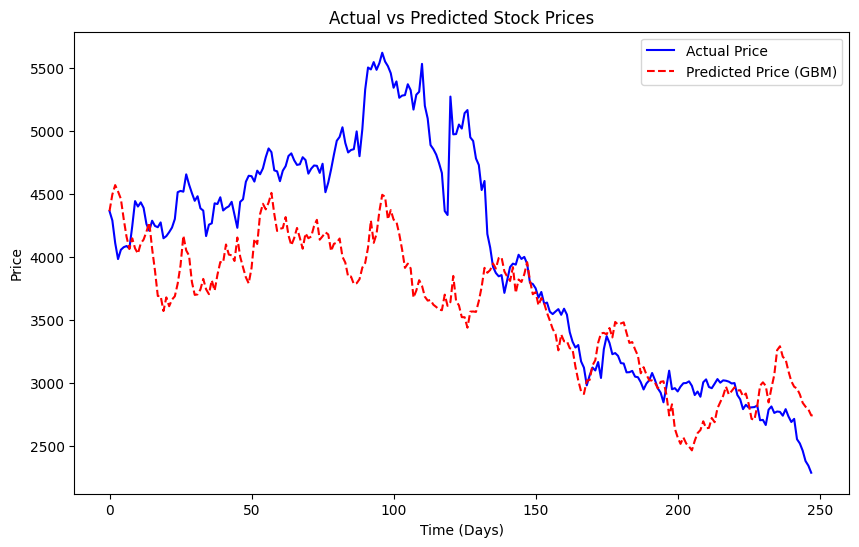

In [90]:
start_price = actual_prices[0]

log_returns = np.log(actual_prices[1:] / actual_prices[:-1])
mu = np.mean(log_returns) * 246
sigma = np.std(log_returns) * np.sqrt(246)


T = 1 #yr
steps = len(actual_prices)
num_simulations = 1000

simulations = simulate_gbm(start_price, mu, sigma, T, steps, num_simulations)

predicted_prices = simulations[0]

plot_stock_data(actual_prices, predicted_prices)

In [91]:
# Backtesting

final_balances = []
for sim in simulations:
    final_balance, roi = optimal_stopping_backtest(sim)
    final_balances.append(final_balance)

mean_balance = np.mean(final_balances)
mean_roi = np.mean([balance / 10000 - 1 for balance in final_balances])
print("Initial Balance : 10000")
print(f"Mean Final Balance: {mean_balance:.2f}")
print(f"Mean Return on Investment (ROI): {mean_roi * 100:.2f}%")

Initial Balance : 10000
Mean Final Balance: 9312.50
Mean Return on Investment (ROI): -6.87%


In [94]:
def probability_of_reaching_price(S0, target_price, mu, sigma, T, time_steps): # P[Ta<t] = 2P(z>|a|/sqrt(t))
    a = target_price
    t = T
    z = (np.log(a / S0) - (mu - 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))

    probability = 2 * (1 - norm.cdf(abs(z)))
    return probability

T = 0.1 # yr
target_price = 2500
current_price = actual_prices[-1]
probability = probability_of_reaching_price(current_price, target_price, mu, sigma, T, steps)
print(f"Current Price : {current_price}")
print(f"Probability of reaching price {target_price} in {T*360:.2f} days: {probability:.4f}")

Current Price : 2287.0
Probability of reaching price 2500 in 36.00 days: 0.2133


In [58]:
def calc_prob_price(actual_prices, simulations, test_price, deviation=0.05): # based on simulated GBM
    reached_times = []

    for sim in simulations:
        time_to_reach = next(
            (t for t, price in enumerate(sim) if abs(price - test_price) <= deviation * test_price),
            None
        )
        if time_to_reach is not None:
            reached_times.append(time_to_reach)

    probability = len(reached_times) / len(simulations)
    avg_time_to_reach = np.mean(reached_times) if reached_times else None

    return probability, avg_time_to_reach

In [62]:
test_price = 2100

probability, avg_time_to_reach = calc_prob_price(actual_prices,simulations, test_price)
print(f"Current Price : {actual_prices[-1]}")
print(f"Probability of reaching price {test_price}: {probability * 100:.2f}%")
print(f"Expected time to reach {test_price}: {np.ceil(avg_time_to_reach)} days")

Current Price : 2287.0
Probability of reaching price 2100: 64.30%
Expected time to reach 2100: 160.0 days
